# Find minimum error using a Gaussian Process

*Last updated Monday, 08 Oct 2021.*

=====================================================================================================

1. **Build input data**

2. **Find GP**

3. **Minimisation**

4. **Results**

=====================================================================================================

#### Model types:

1. Point minimisation: we create a GP fitting the global error (sum of errors per variable).

2. Point minimisation per variable: we create one GP per variable, fitting the individual errors.

3. Region detection: we create one GP per variable, fitting the actual values (from simulations).


#### Notes on error calculation (in R):

We choose to have an error that uses the relative location of sample points, since they all are from the same set of simulated data (error 2). We do not choose the error with real observation 'size' since it gives advantage to variables with more accurate measures. We do not choose error based on relative error, since it takes into account a zero (error 3).

#### Notes on kernel choice:

(For model type = 1 and 3) we choose the Matern kernel with $\mu = 3/2$ since the error function has abrupt changes. $\mu = 1/2$ is too abrupt. Initial lengthscales are $l_{p.orb} = 0.5$ days and $l_{mass} = 0.5 M_{\odot}$.

#### Notes on GP minimisation:

Minimisation is performed on the mean of the GP. Better approaches would minimise $N$ samples from the GP and have a posterior distribution on the event "$x$ is minimum". Even better approaches would use the same principles of Bayesian Optimisation, using an aquisition function or something like that.

Sometimes the minimisation does not work (numerical issues). If so, run it again.

#### Notes on sensitivity analysis:

#### Changes:
- 04.10.2021: Fix model 3 to produce regions for each variable.
- 08.10.2021: Add simulation 2 for non-conservative case.
- 22.12.2021: Correction: variableParameter adapted for non-conservative case

## Load environment

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt

import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

from scipy.optimize import minimize # for finding minimum
import scipy.stats as stats # for sampling from normal

import matplotlib.pyplot as plt

# 0. Set environment
dataSimulations_fixed = pd.read_csv('Output_errorFromR/File20211004_R04_EBVfixed_sim1to3_allErrors1to3.csv', delimiter=',')
dataSimulations_free = pd.read_csv('Output_errorFromR/File20220809_R04_EBVfree_sim2to4_allErrors1to3.csv', delimiter=',')
bounds_fixed = ((2.4, 3.4), (0.9, 2.0))
bounds_free = ((2.3, 2.9), (0.9, 2.0)) # SIM 1: ((2.5, 2.9), (1.0, 1.9))
listRangeX = [ [], [], [], [] ]

# Build auxiliar parameters
errorNames = ['teffError3', 'cnError3', 'massError3', 'mdotError3']
columnNames = ['Teff', 'logCN', 'star_mass', 'lg_mstar_dot_1']
labelNames = ['$T_{eff}$', 'log C/N', 'star mass', 'log accretion']

variableParameter_fixed = [[4382/1000, 326/1000],[-0.5735162, 0.1614067], [0.23, 0.44], [-9.39770384, 0.01597749]]
variableParameter_free = [[4382/1000, 326/1000],[-0.5347448, 0.140955], [0.23, 0.44], [-9.66029, 0.03794868]]
##rangeObs = [[(4382 - 326)/1000, (4382 + 326)/1000],[-0.5735162 - 0.1614067, -0.5735162 + 0.1614067],
##            [0.23, 0.44], [-9.39770384 - 0.01597749, -9.39770384 + 0.01597749]] # median +- sd (0,1,3)
#rangeObs = [[3743.052/1000, 5020.948/1000], [-0.8898674, -0.2571650],
#            [0.23, 0.44], [-9.429019, -9.366389]] # 95% interval for normally distributed (0,1,3)

## Load functions

In [17]:

################################
def getData(case):
    """
    """
    if case == "fixed":
        dataSimulations = dataSimulations_fixed
        bounds = bounds_fixed
        variableParameter = variableParameter_fixed
    else:
        dataSimulations = dataSimulations_free
        bounds = bounds_free
        variableParameter = variableParameter_free
    return dataSimulations, bounds, variableParameter
################################

################################
def getGP(dataSimulations, modelIndex, variableIndex = 0):
    """
    """
    # Construct GP input data
    if modelIndex == 1:
        X_init = dataSimulations[['porb', 'mass']]
        Y_init = np.log(dataSimulations[['totalError2']])
        Y_init = Y_init[['totalError2']].fillna(value = 2) # 10
    elif modelIndex == 2:
        X_init = dataSimulations[['porb', 'mass']]
        Y_init = dataSimulations[[errorNames[variableIndex]]]
        Y_init = Y_init[[errorNames[variableIndex]]].fillna(value = 10)
    else:
        rows_noNA = dataSimulations[[columnNames[variableIndex]]].notna().iloc[:,0]
        X_init = dataSimulations[rows_noNA][['porb', 'mass']]
        Y_init = dataSimulations[rows_noNA][[columnNames[variableIndex]]]/(1 + (variableIndex == 0)*999)
        #X_init = dataSimulations[['porb', 'mass']]
        #Y_init = dataSimulations[[columnNames[variableIndex]]]/(1 + (variableIndex == 0)*99)
        #Y_init = Y_init[[columnNames[variableIndex]]].fillna(
        #    value = max(Y_init[columnNames[variableIndex]]) +
        #    30*(max(Y_init[columnNames[variableIndex]]) - min(Y_init[columnNames[variableIndex]])))
    
    # Run GP
    k = gpflow.kernels.Matern32(lengthscales = [0.5, 0.5])
    m = gpflow.models.GPR(data=(X_init, Y_init), kernel=k, mean_function=None)
    #m.likelihood.variance.assign(0.01) # NEW 01.10.2021
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
    
    return m, X_init, Y_init
################################

################################
# TODO improve
def findMinimum(m, bounds):
    """
    For model 1 and 2
    """
    # Minimise
    def minFn(x):
        mean, var = m.predict_f(np.array([x]))
        return mean.numpy()[0][0]

    # Run minimiser
    x0 = np.array([2.8, 1.2])
    res = minimize(minFn, x0, method='nelder-mead', bounds = bounds)
    
    return res.x
################################

## IV. Plots
################################ IV
def overviewGP(m, case, bounds, modelIndex, minGP, variableIndex = 0):
    """
    """
    
    # generate test points for prediction/interpolation
    n_grid = 200
    x = np.linspace(bounds[0][0] - 0.01, bounds[0][1] + 0.01, n_grid)
    y = np.linspace(bounds[1][0] - 0.01 - (case == "free")*0.04, bounds[1][1] + 0.01, n_grid)
    Xg, Yg = np.meshgrid(x, y)
    X = np.vstack((Xg.flatten(), Yg.flatten())).T

    # predict mean and variance of latent GP at test points
    mean, var = m.predict_f(X)
    meanX = mean.numpy().reshape(n_grid, n_grid)
    varX = var.numpy().reshape(n_grid, n_grid)

    # Compute and store range
    if modelIndex == 3:
        # OLD
        #rangeX = (meanX > rangeObs[variableIndex][0]) & (meanX < rangeObs[variableIndex][1])
        #listRangeX[variableIndex] = rangeX
        # NEW
        ###### It marked as in the region if the distribution of the difference between the samples and
        if not variableIndex == 2:
            # Normally distributed variables
            meanDiff = meanX - variableParameter[variableIndex][0]
            sdDiff = np.sqrt(varX + variableParameter[variableIndex][1]**2)
            rangeX = (stats.norm.ppf(0.025, meanDiff, sdDiff) < 0) & (stats.norm.ppf(0.975, meanDiff, sdDiff) > 0)
        else:
            # Uniformly distributed variables
            # Trick to estimate CI
            # TODO can be done better but I don't know how to do it in python + I don't want to store samples
            sampleAbove0 = np.zeros((n_grid,n_grid))
            sampleSize = 1000
            for ii in range(sampleSize):
                sampleGP = stats.norm.rvs(size = [200, 200], loc = meanX, scale = np.sqrt(varX))
                sampleObs = stats.uniform.rvs(size = [200, 200], loc = variableParameter[variableIndex][0],
                                  scale = variableParameter[variableIndex][1] -
                                              variableParameter[variableIndex][0])
                sampleAbove0 = sampleAbove0 + 1*(sampleGP - sampleObs > 0)
            rangeX = (sampleAbove0/sampleSize < 0.975) & (sampleAbove0/sampleSize > 0.025)
        #listRangeX[variableIndex] = rangeX

    # plot GP
    if modelIndex == 1:
        # TODO
        plt.figure(figsize=(15,5))
        plt.subplot(1, 2, 1)
        plt.contour(x, y, meanX, 100, cmap = "inferno", zorder = 0)
        plt.colorbar()
        plt.scatter(X_init['porb'], X_init['mass'], label = u'Observations', c = "green", alpha = 1, zorder = 1)
        plt.scatter(minGP[0], minGP[1], label = u'Observations', c = "red", zorder = 2)
        plt.xlabel("$P_{orb;i}(days)$")
        plt.ylabel("$M_{donor;i}(M_{\odot})$")
        plt.title("Mean of GP")

        # plot variance of GP
        plt.subplot(1, 2, 2)
        plt.contourf(x, y, varX, 100, cmap = "inferno")
        plt.colorbar()
        plt.scatter(X_init['porb'], X_init['mass'], label=u'Observations', c = "green")
        plt.scatter(minGP[0], minGP[1], label=u'Observations', c = "red")
        plt.xlabel("$P_{orb;i}(days)$")
        plt.ylabel("$M_{donor;i}(M_{\odot})$")
        plt.title("Variance of GP")
    elif modelIndex == 2:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 2, 1)
        plt.contour(x, y, meanX, 100, cmap = "inferno")
        plt.colorbar()
        plt.contourf(x, y, rangeX, cmap = 'binary', alpha = 0.5)
        plt.scatter(X_init['porb'], X_init['mass'], label = u'Observations', c = "green")
        plt.scatter(minGP[0], minGP[1], label = u'Observations', c = "red")
        plt.xlabel("$P_{orb;i}(days)$")
        plt.ylabel("$M_{donor;i}(M_{\odot})$")
        plt.title("Mean of GP for %s" % labelNames[variableIndex])

        # plot variance of GP
        plt.subplot(1, 2, 2)
        plt.contourf(x, y, varX, 100, cmap = "inferno")
        plt.colorbar()
        plt.scatter(X_init['porb'], X_init['mass'], label=u'Observations', c = "green")
        plt.scatter(minGP[0], minGP[1], label=u'Observations', c = "red")
        plt.xlabel("$P_{orb;i}(days)$")
        plt.ylabel("$M_{donor;i}(M_{\odot})$")
        plt.title("Variance of GP for %s" % labelNames[variableIndex])
    else:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 2, 1)
        #NO plt.contour(x, y, meanX, 100, colors='k') # cmap = "inferno"
        plt.contourf(x, y, meanX, 100, cmap = "inferno", alpha = 0.3)
        plt.colorbar()
        plt.contourf(x, y, rangeX, cmap='binary', alpha = 0.5)
        plt.scatter(X_init['porb'], X_init['mass'], label=u'Observations', c = "green")
        #NO plt.scatter(x[np.where(meanX == np.amin(meanX))[1]],
        #            y[np.where(meanX == np.amin(meanX))[0]], label=u'Observations', c = "red")
        ###plt.scatter(minGP[0], minGP[1], label=u'Observations', c = "red")
        plt.xlabel("$P_{orb;i}(days)$")
        plt.ylabel("$M_{donor;i}(M_{\odot})$")
        plt.title("Mean of GP for %s" % labelNames[variableIndex])

        # plot variance of GP
        plt.subplot(1, 2, 2)
        plt.contourf(x, y, varX, 100, cmap = "inferno")
        plt.colorbar()
        plt.scatter(X_init['porb'], X_init['mass'], label=u'Observations', c = "green")
        ###plt.scatter(minGP[0], minGP[1], label=u'Observations', c = "red")
        plt.xlabel("$P_{orb;i}(days)$")
        plt.ylabel("$M_{donor;i}(M_{\odot})$")
        plt.title("Variance of GP for %s" % labelNames[variableIndex])
    if modelIndex == 1:
        return(x, y, meanX)
    elif modelIndex == 3:
        return(x, y, meanX, rangeX)
################################

<code>modelIndex</code>

1: point minimisation 2: point minimisation per variable 3: region

<code>variableIndex</code> (relevant for models 2 and 3)

0: T_eff 1: log C/N 2: star mass 3: log accretion

## Run model 1

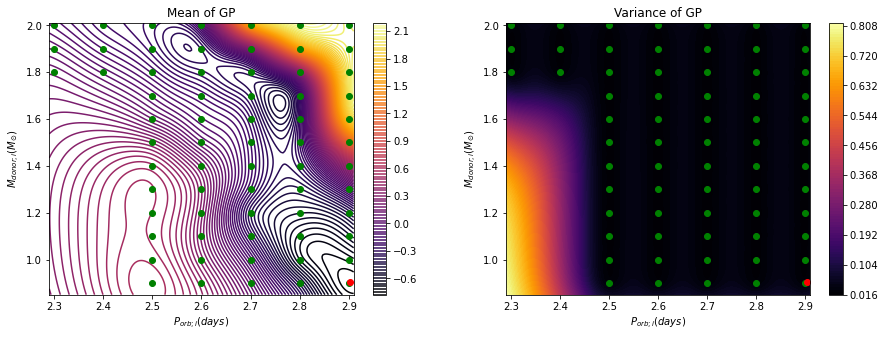

In [18]:
case = "free" # CHOOSE: "fixed" "free"

# Model 1
dataSimulations, bounds, variableParameter = getData(case = case)
modelGP, X_init, Y_init = getGP(dataSimulations, modelIndex = 1)
minGP = findMinimum(m = modelGP, bounds = bounds)
x, y, meanX = overviewGP(m = modelGP, case = case, bounds = bounds, modelIndex = 1, minGP = minGP)

Plot for PDF:

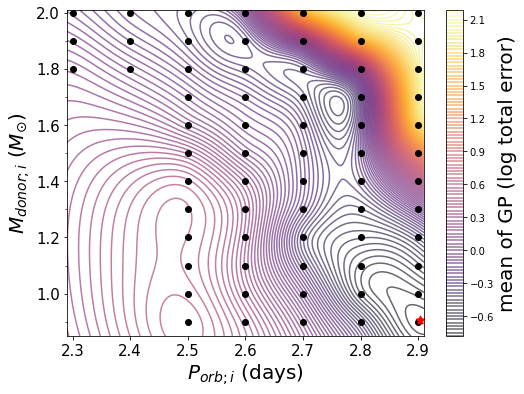

In [19]:
# Save plot of mean GP
plt.figure(figsize=(8,6))

if case == "fixed":
    ticksListX = np.arange(0, 50, 5)/10
else:
    ticksListX = np.arange(0, 50, 1)/10
ticksListY = np.arange(0, 50, 2)/10

plt.contour(x, y, meanX, 100, cmap = "inferno", alpha = 0.6, zorder = 0)
cbar = plt.colorbar()
plt.scatter(X_init['porb'], X_init['mass'], label = u'Observations', c = "black", alpha = 1, zorder = 1)
plt.scatter(minGP[0], minGP[1], label = u'Observations', c = "red", marker=(5, 1), s = 80, zorder = 2)
plt.xlabel("$P_{orb;i}$ (days)", size = 20)
plt.xticks(ticksListX[(ticksListX >= bounds[0][0]) & (ticksListX <= bounds[0][1])], size = 15)
plt.ylabel("$M_{donor;i}$ $(M_{\odot})$", size = 20)
plt.yticks(ticksListY[(ticksListY >= bounds[1][0]) & (ticksListY <= bounds[1][1])], size = 15)

ax = plt.gca()
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

cbar.set_label('mean of GP (log total error)', size = 20)

#plt.savefig('../Plots/Plot04102021_GP_conservative.pdf') # sim 1-3
#plt.savefig('../Plots/Plot04102021_GP_nonconservative.pdf') # sim 1
#plt.savefig('../Plots/Plot08102021_GP_nonconservative.pdf') # sim 1-2

Save minimum from model 1 to use in plots for later models

In [20]:
minGP_model1 = minGP

## Run model 3

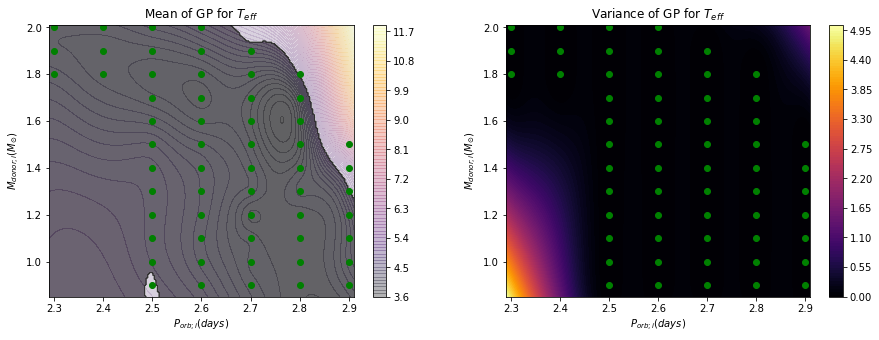

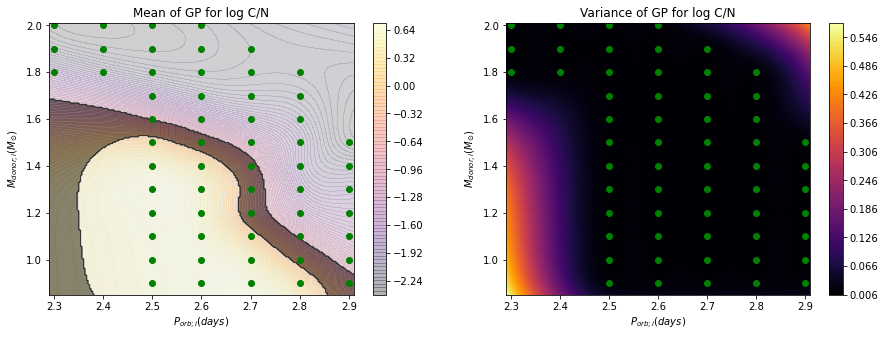

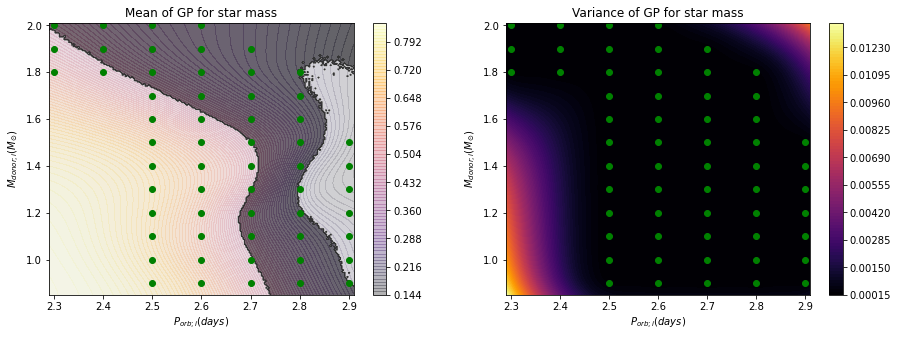

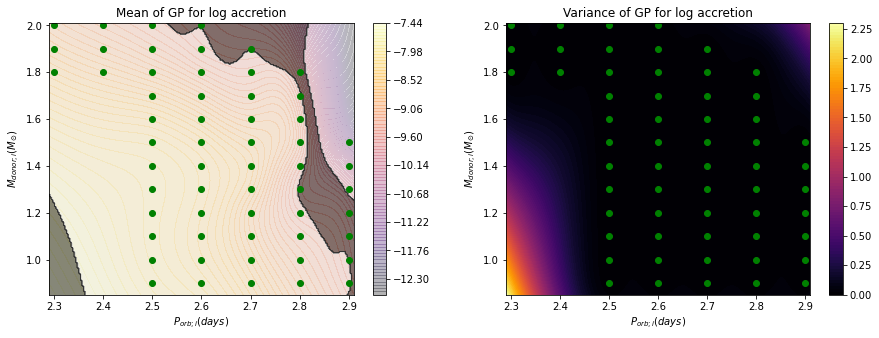

In [22]:
case = "free" # CHOOSE: "fixed" "free"

# Model 3
for variableIndex in range(4):
    dataSimulations, bounds, variableParameter = getData(case = case)
    modelGP, X_init, Y_init = getGP(dataSimulations, modelIndex = 3, variableIndex = variableIndex)
    minGP = findMinimum(m = modelGP, bounds = bounds)
    x, y, meanX, rangeX = overviewGP(m = modelGP, case = case, bounds = bounds, modelIndex = 3, minGP = minGP,
               variableIndex = variableIndex)
    listRangeX[variableIndex] = rangeX

Plot for PDF:

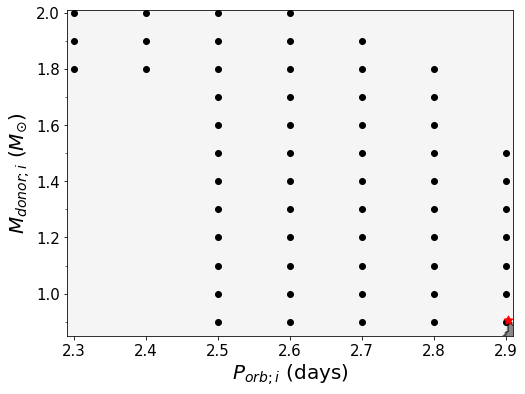

In [23]:
prodRangeX = listRangeX[0]*listRangeX[1]*listRangeX[2]*listRangeX[3]
#prodRangeX = listRangeX[0]*listRangeX[1]*listRangeX[3]
#prodRangeX = listRangeX[3]

minGP = minGP_model1

## plot region
#plt.figure(figsize=(8,6))
#plt.contourf(x, y, prodRangeX, cmap='binary', alpha = 0.5)
#plt.scatter(X_init['porb'], X_init['mass'], label=u'Observations', c = "green")
#plt.scatter(minGP[0], minGP[1], label=u'Observations', c = "red")
#plt.xlabel("$P_{orb;i}(days)$")
#plt.ylabel("$M_{donor;i}(M_{\odot})$")

# Save plot of mean GP
plt.figure(figsize=(8,6))
if case == "fixed":
    ticksListX = np.arange(0, 50, 5)/10
else:
    ticksListX = np.arange(0, 50, 1)/10
ticksListY = np.arange(0, 50, 2)/10
plt.contourf(x, y, prodRangeX, cmap = 'binary', alpha = 0.5, zorder = 0)
plt.scatter(X_init['porb'], X_init['mass'], label = u'Observations', c = "black", alpha = 1, zorder = 1)
plt.scatter(minGP[0], minGP[1], label = u'Observations', c = "red", marker = (5, 1), s = 80, zorder = 2)
plt.xlabel("$P_{orb;i}$ (days)", size = 20)
plt.xticks(ticksListX[(ticksListX >= bounds[0][0]) & (ticksListX <= bounds[0][1])], size = 15)
plt.ylabel("$M_{donor;i}$ $(M_{\odot})$", size = 20)
plt.yticks(ticksListY[(ticksListY >= bounds[1][0]) & (ticksListY <= bounds[1][1])], size = 15)

ax = plt.gca()
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

#plt.savefig('../Plots/Plot04102021_Region_conservative.pdf')
#plt.savefig('../Plots/Plot04102021_Region_nonconservative.pdf')

## Overview of results

### Review kernel (all models)

In [43]:
print_summary(modelGP)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,63.4681381680557
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.51666411 2.42249877]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


### Minimum value (applies for model 1. and 2.)

In [12]:
minGP

array([2.81037578, 1.02471291])

### Plot range and save (applies for model 3.)

NameError: name 'y' is not defined

<Figure size 576x432 with 0 Axes>

### Overview of GP in 2D (choose mass)

In [52]:
X_init = dataSimulations[['porb', 'mass']]
Y_init = dataSimulations[[columnNames[variableIndex]]]
Y_init = Y_init[[columnNames[variableIndex]]].fillna(
    value = max(Y_init[columnNames[variableIndex]]) +
    30*(max(Y_init[columnNames[variableIndex]]) - min(Y_init[columnNames[variableIndex]])))

rows_noNA = dataSimulations[[columnNames[variableIndex]]].notna().iloc[:,0]
X_init = dataSimulations[rows_noNA][['porb', 'mass']]
Y_init = dataSimulations[rows_noNA][[columnNames[variableIndex]]]


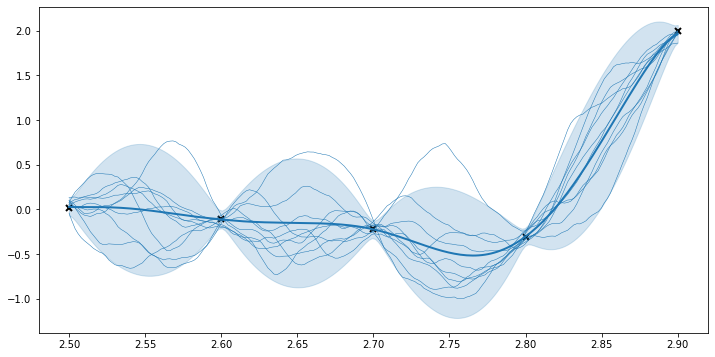

In [14]:
massToPlot = 1.6

## points from simulation
X_sim = X_init.loc[(X_init['mass'] == massToPlot)][['porb']]
Y_sim = Y_init.loc[(X_init['mass'] == massToPlot)].iloc[:,0]

## generate test points for prediction
n_grid = 200
x_sample = np.linspace(bounds[0][0], bounds[0][1], n_grid)
y_sample = np.linspace(massToPlot, massToPlot, 1)
Xg_sample, Yg_sample = np.meshgrid(x_sample, y_sample)
X_sample = np.vstack((Xg_sample.flatten(), Yg_sample.flatten())).T

## predict mean and variance of latent GP at test points
mean_sample, var_sample = m.predict_f(X_sample)
meanX_sample = mean_sample.numpy().reshape(n_grid, 1)
varX_sample = var_sample.numpy().reshape(n_grid, 1)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(X_sample, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X_sim, Y_sim, "kx", mew=2)
plt.plot(x_sample, mean_sample, "C0", lw=2)
plt.fill_between(
    X_sample[:, 0],
    meanX_sample[:, 0] - 1.96 * np.sqrt(varX_sample[:, 0]),
    meanX_sample[:, 0] + 1.96 * np.sqrt(varX_sample[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(x_sample, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)


### Store plot for model 1.

In [59]:
# Save plot of mean GP
plt.figure(figsize=(8,6))
if typ == "fixed":
    ticksListX = np.arange(0, 50, 5)/10
else:
    ticksListX = np.arange(0, 50, 1)/10
ticksListY = np.arange(0, 50, 2)/10
plt.contour(x, y, meanX, 100, cmap = "inferno", alpha = 0.6, zorder = 0)
cbar = plt.colorbar()
plt.scatter(X_init['porb'], X_init['mass'], label = u'Observations', c = "black", alpha = 1, zorder = 1)
plt.scatter(minGP[0], minGP[1], label = u'Observations', c = "red", marker=(5, 1), s = 80, zorder = 2)
plt.xlabel("$P_{orb;i}$ (days)", size = 20)
plt.xticks(ticksListX[(ticksListX >= bounds[0][0]) & (ticksListX <= bounds[0][1])], size = 15)
plt.ylabel("$M_{donor;i}$ $(M_{\odot})$", size = 20)
plt.yticks(ticksListY[(ticksListY >= bounds[1][0]) & (ticksListY <= bounds[1][1])], size = 15)

ax = plt.gca()
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

cbar.set_label('mean of GP (log total error)', size = 20)

#plt.savefig('../Plots/Plot04102021_GP_conservative.pdf') # sim 1-3
#plt.savefig('../Plots/Plot04102021_GP_nonconservative.pdf') # sim 1
#plt.savefig('../Plots/Plot08102021_GP_nonconservative.pdf') # sim 1-2


NameError: name 'typ' is not defined

<Figure size 576x432 with 0 Axes>

In [92]:
sampleAbove0 = np.zeros((n_grid,n_grid))
sampleSize = 500
for ii in range(sampleSize):
    sampleGP = stats.norm.rvs(size = [200, 200], loc = meanX, scale = np.sqrt(varX))
    sampleObs = stats.uniform.rvs(size = [200, 200], loc = variableParameter[variableIndex][0],
                      scale = variableParameter[variableIndex][1] - variableParameter[variableIndex][0])
    sampleAbove0 = sampleAbove0 + 1*(sampleGP - sampleObs > 0)
(sampleAbove0/sampleSize < 0.975) & (sampleAbove0/sampleSize > 0.025)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [57]:
#prodRangeX = listRangeX[0]*listRangeX[1]*listRangeX[3]#*listRangeX[3]
listRangeX[1]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])